In [1]:
import gym
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
class TicTacToe:
    def __init__(self, state=None):
        # turn is X=1, 0=-1
        self.reset()
        if state is not None:
            self.state = state
        if isinstance(self.state, torch.Tensor):
            # internally state is a list (faster)
            self.state = self.state.tolist()
    
    class action_space:
        n = 9
    
    class observation_space:
        n = 11 # board, done, turn
    
    def reset(self):
        self.state = [0] * 11
        self.state[-1] = 1
        self.state[-2] = 0
        return self.state
    
    def __str__(self):
        s = str(torch.Tensor(self.state[:9]).view(3,3))
        s += '\nturn: ' + str(self.state[-1])
        return s
    
    def render(self):
        print(str(self))
        
    # 0 for draw/ongoing, 1 for Xwin, -1 for Owin
    @staticmethod
    def value(state):
        board = state[0:9]
        for turn in [1, -1]:

            for i in range(3):
                # horizontal
                if all(board[i*3 + j] == turn for j in range(3)):
                    return turn
            
                # virtical
                if all(board[j+i] == turn for j in (0,3,6)):
                    return turn
            
            # diagonals
            if all(board[i] == turn for i in (0, 4, 8)):
                return turn
            
            if all(board[i] == turn for i in (2, 4, 6)):
                return turn
        
        return 0
    
    @classmethod
    def is_done(cls, pos):
        return cls.value(pos) != 0 or all(pos[i] != 0 for i in range(9))
    
    @classmethod
    def dynamics(cls, state, act):
        state = state.copy()
        assert state[-1] in (1, -1)
        assert 0 <= act <= 8
        
        rew = 0
        if state[act] != 0:
            raise ValueError(f'illegal move, {act} occupied {state}')
            
        state[act] = state[-1]
        state[-1] *= -1
        rew = cls.value(state)
        if rew != 0 or all(state[i] != 0 for i in range(9)):
            state[-2] = 1 # done=True
            
        return rew, state

    
    def step(self, act):
        rew, self.state = TicTacToe.dynamics(self.state, act)

        
        return self.state, rew, bool(self.state[-2]), None
    
    @staticmethod
    def legal(state):
        for i in range(9):
            if state[i] == 0:
                yield i
                
        

tests = [
    (
        [[1, 1, 1],
         [0, 0, 0],
         [-1,0,-1]],
        1,
    ),
    (
        [[1, 0, 1],
         [0, 0, 0],
         [-1,-1,-1]],
        -1,
    ),
    (
        [[1, -1, 1],
         [1, 0, 0],
         [1,-1,-1]],
        1,
    ),
    (
        [[1, 0, 0],
         [0, 1, 0],
         [0, 0, 1]],
        1,
    ),
    (
        [[0, 0, 1],
         [0, 1, 0],
         [1, 0, 1]],
        1,
    )
]

for test in tests:
    state, val = test
    tic = TicTacToe(state)
    got_val = tic.value([t for subl in state for t in subl]) # flatten
    assert got_val == val, f'want {val} got {got_val} on\n{tic}'

In [4]:
def negamax(env, obs, alpha, beta): # -> (act, val)
    turn = obs[-1]
    best_act = None
    if obs[-2]:
        # negamax relative score!
        return best_act, turn * env.value(obs)
    

    for act in env.legal(obs):
        _rew, new_obs = env.dynamics(obs, act)
        
        # beta=-alpha for child since they cannot exeed our best score or
        # we won't go down this path
        # alpha=-beta for child since their best will be our upper bound
        _act, val = negamax(env, new_obs, -beta, -alpha)
        val *= -1
        
        # if we exceed our upper bound return
        if val >= beta:
            return best_act, beta

        if val > alpha:
            best_act = act
            alpha = val
            
        
    return best_act, alpha


def search(env, obs):
    mv, val = negamax(env, obs, alpha=float('-inf'), beta=float('inf'))
    return mv, val * obs[-1]

In [5]:
env = TicTacToe()
obs = env.reset()
mv, val = search(TicTacToe, obs)
assert val == 0, val
print(mv)

0


In [6]:
#%timeit search(TicTacToe, obs)
# Was super slow earlier, got it down to ~7us, could get lower with numba jit or cython if I really cared
#%timeit env.value(obs)

In [7]:
# NERUAL NETWORK TIME FUCK YEAH

In [8]:
# 1. Become one with the dataset
def compute_label(state):
    _, val = search(TicTacToe, state.tolist())
    return val

def get_dataset(N):
    positions = torch.randint(low=-1, high=2, size=(N,9))
    turns = torch.randint(low=0, high=2, size=(N,))*2 - 1
    dones = torch.Tensor([1 if TicTacToe.is_done(pos) else 0 for pos in positions])

    states = torch.cat((positions, dones.view(N,1), turns.view(N,1)), dim=1)
    assert not torch.isinf(states).any()

    labels = torch.Tensor([compute_label(state) for state in states]).view(N, 1)
    assert not torch.isinf(labels).any()
    
    dataset = (states.to(device), labels.to(device))
    return dataset

N = 1000
dataset = get_dataset(N)
states, labels = dataset


In [9]:
TicTacToe(states[0]).render()

tensor([[-1.,  1.,  0.],
        [ 0., -1.,  1.],
        [ 0.,  1.,  0.]])
turn: -1.0


In [10]:
# 2. Super basic nerual network

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(TicTacToe.observation_space.n, 8)
        self.fc2 = nn.Linear(8, 8)
        self.fc3 = nn.Linear(8, 8)
        self.fc4 = nn.Linear(8, 1) # eval, orig tried to output moves, but was not working.
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    

In [12]:
losses = []

net = Net()
net.to(device)

loss_fn = nn.MSELoss()

print(net)

Net(
  (fc1): Linear(in_features=11, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)


In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.05)

for epoch in range(1000):
    # TODO: minibatches
    batch = states
    output = net.forward(batch)
    net.zero_grad()

    loss = loss_fn(output, labels)
    losses.append(loss)
    print(f'epoch {epoch} loss {loss}' + ' '*30, end='\r', flush=True)
    loss.backward()
    optimizer.step()

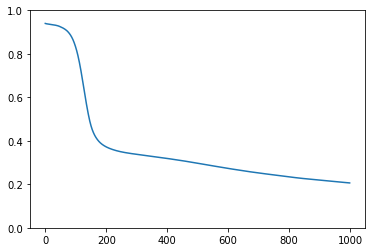

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.ylim([0, 1])
plt.plot(losses)
plt.show()

In [15]:
test_states, test_labels = get_dataset(1000)


In [16]:
# Compute accuracy
def accuracy(test_states, test_labels):
    predicted_vals = net.forward(test_states)
    return (predicted_vals.round() == test_labels).sum() / N

accuracy(test_states, test_labels)

tensor(0.7830, device='cuda:0')

In [17]:
accuracy(states, labels)

tensor(0.8070, device='cuda:0')